# L10 - Introduction to Text Analytics

## Author - Rodolfo Lerma

## Introduction 

# `Section 10A`

### Text Data Are Everywhere

Raw text data is an unstructured and ubiquitous type of data. Most of the world’s data is unstructured. Volumes of unstructured data, including text, are growing much faster than structured data. There are many industry estimates for the fraction of all data which is unstructured. A few from the last 8 years include:   
- 2009 HP Survey: 70%
- Gartner: 80%
- Teradata: 85%
- But, **Beware of industry estimates!!**

How much text data are we talking about here? In a few years time, Twitter has more text data recorded than all that has been written in print in the history of mankind. (http://www.internetlivestats.com/twitter-statistics/)

### Applications of Text Analytics

Given the ubiquity and volume of text data, it is not surprising that numerous powerful applications which exploit text analytics are appearing. A few of these applications are listed below.

- Intelligent applications
  - Assistants
  - Chat bots
- Classification
  - Sentiment analysis
  - SPAM detection
- Speech recognition
- Search
- Information retrieval
- Legal discovery

### Analysis of Text Data

In this tutorial we investigate three areas of text analytics. The following three sections cover these topics.

- Preparing text for analysis.
- Classification of text and sentiment analysis.
- Topic Models for document classification and retrieval. 

We start by loading the necessary libraries for this jupyter notebook script.

In [1]:
# Import necessary libraries
import csv
#import lda
import editdistance
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Specialty libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from collections import Counter
import argparse
import pprint
import gensim

In [3]:
# from glove import Glove
# from glove import Corpus

In [4]:
nltk.download('wordnet')
nltk.download('stopwords')

# If you get an SSL-certificate error, and you are on a MAC then you may have to navigate to: application/python3/ and
# run/double-click on the command 'install certificates'.  Then try this again.

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ly266e\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ly266e\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk.stem.wordnet import WordNetLemmatizer

#### Preparing  text data

By its very nature, text data comes unstructured and poorly organized for analysis. Typically multiple steps are required to process text into a form suitable for analysis. You can think of this process as transforming the unstructured data into a structured set of features. 

Steps covered in this tutorial include the following:

- Organize text documents into a corpus
- Normalize the text to remove unneeded content
  - Tokenize text
  - Clean text
- Create term document matrix

#### Text analysis methods

There are a great many approaches which have been tried for text analytics and natural language processing (NLP). We only mention a few below. 

- The **bag of words model** is a simple widely used and surprisingly effective model for analysis of text data. The BOW model uses only on the frequency of the words in the document and order of the words is not considered. Despite these seemingly ridiculous assumptions, the model works well in many cases. 
  - The BOW model assumes **exchangeability** of words. 
  - The end product of applying the BOW model is a term-document or document-term matrix. The tdm, or dtm is a structured representation of word frequency by document. 
  - The tdm or dtm can be used for classification if labels are available or clustering for unsupervised learning. 
- Other powerful models are the **word to vec** and **doc to vec** models. Word to vec, uses a neural network model to determine similarity between words. These models are beyond the scope of this tutorial. You can find a good introduction to this model in the [article by Rong](https://arxiv.org/pdf/1411.2738.pdf)
- Another widely used model is of **Part of Speech (PoS) Tagging**. PoS tagging attempts to label or annotate words in a corpus (e.g. a collection of documents) as, say nouns, verbs, pronouns, etc. PoS tagging is beyond the  scope of this tutorial. The PoS tagger creates a tree of the relationship of words in say a sentence. One useful specialization of PoS tagging is named entity recognition, which attempts to find proper nouns. 

  


To start with quantifying text, we will first consider measuring a distance between text (strings).

## Quantifying Text

With data we can easily ask what is the distance between numeric data points. It is harder to answer that question with text data. There are ways to quantify the distance between different text but we have to be specific on how we measure the distance.

### Measuring Text Distance

Measuring the distance between words in a document is not as straight forward as it might seem. The choice of distance metric can have a significant effect on analytical results. This is particularly the case for unsupervised learning methods like cluster models. 

Let's look at a few of the commonly used distance metrics. 

**Hamming Distance**
- Line up strings, count number of positions that are the different.
- Assumes strings are of the same length.

$$𝐻𝑎𝑚𝑚𝑖𝑛𝑔(101101, 100011)=3\\
𝐻𝑎𝑚𝑚𝑖𝑛𝑔(𝑏𝑒𝑒𝑟,𝑏𝑒𝑎𝑟)=1$$

**Levenshtein distance** also called the 'edit distance', measure the distance between two strings (insertion, deletion, substitution only):

$$𝐿𝑒𝑣(𝑏𝑒𝑒𝑟,𝑏𝑒𝑎𝑟)=1\\
𝐿𝑒𝑣(𝑏𝑎𝑛𝑎𝑛𝑎,𝑏𝑎𝑛)=3$$

**Jaccard index** measures the size of intersection of characters divided by size of union of characters.

$$J(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|}\\
J(beer, bear) = 1 - \frac{3}{4}\\
J(bannana, ban) = 1 - \frac{3}{3} \leftarrow\ This\ is\ a\ problem$$

**Weighted Jaccard Index** For each letter, calculate the minimum times it appears, $m_i$, and the maximum number of times it appears, $M_i$.

$$J'(A, B) = 1 - \frac{\sum m_i}{\sum M_i}\\
J'(beer, bear) = 1 - \frac{m_a + m_e + m_b + m_r}{M_a + M_e + M_b + M_r}\\
J'(beer, bear) = 1 - \frac{0 + 1 + 1 + 1}{1 + 1 + 2 + 1}=1-\frac{3}{5} = \frac{2}{5}\\
J'(banana, ban) = 1 - \frac{1 + 1 + 1}{3 + 1 + 2}=\frac{1}{2}$$

Next we show how to implement these distances with python.

In [6]:
# Hamming Distance
def hamming_dist(text1, text2):
    # For strings of equal length:
    assert len(text1) == len(text2)
    return sum(char1 != char2 for char1, char2 in zip(text1, text2))

print('Hamming(101101, 100011) = {}'.format(hamming_dist('101101', '100011')))
print('Hamming(bear, beer) = {}'.format(hamming_dist('bear', 'beer')))

Hamming(101101, 100011) = 3
Hamming(bear, beer) = 1


In [7]:
# Levenshtein Distance (edit distance)
print('Lev_Dist(bear, beer) = {}'.format(editdistance.eval('bear', 'beer')))

print('Lev_Dist(banana, ban) = {}'.format(editdistance.eval('banana', 'ban')))

Lev_Dist(bear, beer) = 1
Lev_Dist(banana, ban) = 3


In [8]:
# Jaccard Index Distance
def jaccard_ix_dist(text1, text2):
    set1 = set(list(text1))
    set2 = set(list(text2))
    return 1 - (len(set1.intersection(set2)) / float(len(set1.union(set2))))


print('Jaccard(bear, beer) = {}'.format(jaccard_ix_dist('beer', 'bear')))

# The following may be an issue...
print('Jaccard(banana, ban) = {}'.format(jaccard_ix_dist('banana', 'ban')))

Jaccard(bear, beer) = 0.25
Jaccard(banana, ban) = 0.0


In [9]:
# Weighted Jaccard Index
def weighted_jaccard_dist(text1, text2):
    set1 = set(list(text1))
    set2 = set(list(text2))
    union = set1.union(set2)
    
    min_sum = 0
    max_sum = 0
    for char in union:
        min_sum += min(text1.count(char), text2.count(char))
        max_sum += max(text1.count(char), text2.count(char))
    
    return 1 - (min_sum / max_sum)

print('Weighted Jaccard(bear, beer) = {}'.format(weighted_jaccard_dist('beer', 'bear')))

print('Weighted Jaccard(banana, ban) = {}'.format(weighted_jaccard_dist('banana', 'ban')))

Weighted Jaccard(bear, beer) = 0.4
Weighted Jaccard(banana, ban) = 0.5


## Your Turn 1
What is the weighted jaccard distance between the phrase 'open the pod bay doors, hall' and 'Open the pod-bay doors Hall!'?

In [10]:
a = 'open the pod bay doors, hall'
b = 'Open the pod-bay doors Hall!'

In [11]:
print('Weighted Jaccard(a, b) = {}'.format(weighted_jaccard_dist(a, b)))

Weighted Jaccard(a, b) = 0.25


## Text Cleaning and Preprocessing

The very first step to prepare text is to clean it.  We clean and normalize the text by performing various operations on the text. Some examples are as follows:

 - Lowercase the text.
 - Remove symbols and/or punctuation.
 - Remove numbers. May also replace all numbers with a numeric tag, for example `<NUM>` or similar. We may also consider replacing all dates with `<DATE>` or similarly use tags `<URL>`, `<PHONE>`, `<EMAIL>`, etc...
 - Strip extra white space. White space has many forms: space, newline, or tab. There are also other rarely used unicode specifications for other white space characters.
 - Remove all non-printable unicode characters.
 - Replace accent characters (For example: N̈ --> N).
 - Remove 'stop words'. Stop words are generally non-informative words like 'the, as, a, ours, etc...'
 - Stem words to similar endings. (For example: 'statistics', 'statistical', 'statistic' --> 'statisti')
 - Create bi-grams (or tri-grams, or N-grams, ...). (For example, 'out of date' --> 'out-of-date' or 'out_of_date')
 
There are a few reasons to clean your text.  The primary reason is to reduce the potential vocabulary and increase the observations of specific words (or tokens).  When considering which of the above steps to apply in your text analysis or NLP project, consider how you want the problem at hand to treat different instances of tokens.  Ask yourself questions like "Do I want to consider the words 'China' and 'china' to be different?" In the prior example one is a country and the other is a plate. Or maybe numbers are important in our text. The answers to these questions determine which pre-processing steps to perform and is very problem specific.

***
**Note**: Be careful dealing with unicode characters. There are many editors and text viewers that only display printable characters but will not remove non-printable characters. Strange unicode characters can end up in data from users blindly copy/pasting text (with invisible unicode) into other text boxes.
***

In [12]:
# Text cleaning example
horrible_tweet_text = 'I <3 statistics $\ \ $, it’s my \u1072  $\ \ $    fAvoRitE!! 11!!!'
print('Unfiltered text: \n{}\n'.format(horrible_tweet_text))


Unfiltered text: 
I <3 statistics $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!!



In [13]:
# Remove non-ascii unicode
clean1 = ''.join([x for x in horrible_tweet_text if ord(x) < 128])
print('Removed non-ascii unicode: \n{}\n'.format(clean1))


Removed non-ascii unicode: 
I <3 statistics $\ \ $, its my   $\ \ $    fAvoRitE!! 11!!!



In [14]:
# Remove uppercase
clean2 = clean1.lower()
print('Lowercased: \n{}\n'.format(clean2))

Lowercased: 
i <3 statistics $\ \ $, its my   $\ \ $    favorite!! 11!!!



In [15]:
# Remove punctuation
exclude = set(string.punctuation)
clean3 = ''.join(char for char in clean2 if char not in exclude)
print('No Punctuation: \n{}\n'.format(clean3))

No Punctuation: 
i 3 statistics    its my         favorite 11



In [16]:
# Remove numbers
clean4 = re.sub("\d+", "", clean3)
print('Removed numbers: \n{}\n'.format(clean4))


Removed numbers: 
i  statistics    its my         favorite 



In [17]:
# Strip extra whitespace
clean5 = ' '.join(clean4.split())
print('Stripped extra whitespace: \n{}\n'.format(clean5))

Stripped extra whitespace: 
i statistics its my favorite



In [18]:
# Remove stopwords
word_list = clean5.split(' ')
clean_word_list = [word for word in word_list if word not in stopwords.words('english')]
clean6 = ' '.join(clean_word_list)
print('Removed stopwords like: {} ...'.format(stopwords.words('english')[0:5]))
print(clean6)

Removed stopwords like: ['i', 'me', 'my', 'myself', 'we'] ...
statistics favorite


In [19]:
# Stem Words
lmtzr = WordNetLemmatizer()
stemmed_words = [lmtzr.lemmatize(word) for word in clean_word_list]
clean7 = ' '.join(stemmed_words)
print('\nStemmed Words: \n{}\n'.format(clean7))


Stemmed Words: 
statistic favorite



In [20]:
# Create a function to do this
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']
print(preprocess(horrible_tweet_text, step_list))

statistic favorite


## Your Turn 2

What is the expected differences between the following commands?
the world ``statistics``. One of them should have the statistics and the other statistic.

And why are they different?
Because of the order of cleaning and preprocessing. In the first case when the word is lemmatized includes the 200 end, therefore that is what it will remove. In the second case that ending was already removed and therefore can look for other endings to generalized the word, which in this case is the letter *s*.

`my_string = 'We took statistics200'`

 1. `preprocess(my_string, ['stem_words', 'remove_numbers'])`
 2. `preprocess(my_string, ['remove_numbers', 'stem_words'])`
 
Can you think of any other examples where the order of preprocessing text matters?
- As seen in this example, every time we have a words with numbers (or the possibility that we might have those situations) 
- In general every time a word might be concatenated with other characters (including punctuation). 

In [21]:
my_string = 'We took statistics200'

In [22]:
preprocess(my_string, ['stem_words', 'remove_numbers'])

'We took statistics'

In [23]:
preprocess(my_string, ['remove_numbers', 'stem_words'])

'We took statistic'

# `Section 10B`

## Text Preparation
Unstructured text must be processed into a uniform set of features suitable for further analysis. In this section we will step through some of the commonly used methods for converting unstructured text into a form we can use for analysis. There are four steps we need to transform text into a set of features we can analyze.  

- **Clean** the texts entries (see above section).
- **Tokenize** the document.
- **Normalize** the text. 
- Compute the **term-document matrix** or **document-term matrix**.

### Tokenize Text

As a first step in preparing text for analysis of a document is to **tokenize** the text. In general terms, tokenization is the process dividing raw text into words, symbols and other elements, known as **tokens**. A set of tokens from one or more documents is known as a **corpus**.

As a first step in creating a corpus is reading the data set. This particular data set is comprised of 160,000 tweets. The sentiment of these tweets has been human labeled as positive or negative {0,4}. The code in the cell below reads the tweet text and sentiment. The sentiment is marked as {0,1} for positive and negative. Run this code to load the data. 

In [24]:
# Read the Tweet dataset
data_file = 'twitter_data.csv'
tweet_df = pd.read_csv(data_file)

tweet_df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [25]:
# But sentiment is either '4' or '0'. We'll change that to '1' or '0' to indicate positive or negative sentiment.
tweet_df.sentiment_label=tweet_df.sentiment_label.replace(4,1)

# Check the Data frame again
print(tweet_df.head())

print('\n\n{}'.format(tweet_df['sentiment_label'].describe()))

print('\n\n Count of positives: {}'.format(np.sum(tweet_df['sentiment_label'])))

   sentiment_label                                         tweet_text
0                1  @elephantbird Hey dear, Happy Friday to You  A...
1                1  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


count    160000.000000
mean          0.500000
std           0.500002
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: sentiment_label, dtype: float64


 Count of positives: 80000


In [26]:
# Convert a copy of the tweets as list for use later
tweet_data = tweet_df.values.tolist()

In [66]:
# tweet_data

<div style="border-radius: 3px; background-color: #f5f5f5; padding: 5px;">
The following code has been updated to reflect the data set location.
</div>

Now that we have the data set read, we need to clean then tokenize the tweets.

***
**Note**: Becareful stemming on a large dataset. Stemming is the slowest procedure in the list and can really slow you down. For demonstration purposes, we will not perform stemming.
***

In [28]:
# Clean tweets
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace']

tweet_df['clean_tweet'] = tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))

In [29]:
tweet_df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if hes not...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom has closed ...


### Term Document Matrix (Quiz Point 1)

Now that we have a corpus with some basic normalization applied, we can create a **term document matrix (tdm)** The tdm is a representation of **Bag of Words** model. The tdm has the following properties:

- Frequencies of a given term  are in the rows. The **term frequencies (TF)** for each document are in the columns
- The tdm is a sparse matrix, as most documents do not include many of the terms. Sparse matrix coding must be used for efficiency. 
- **Document term matrix (dtm)** is transpose
- Using the distribution of a document’s TF or **term frequency inverse document  frequency (TF-IDF)** values a number of analyses can be performed, including:
  - Characterize writing styles
  - Comparing authors
  - Determining original authors
  - Finding plagiarism

Let's look at an example of a tdm. The figure below shows a corpus of text documents on the left. This corpus is transformed into the term document matrix shown on the right. Notice that the matrix is sparse as any given document may not contain a term. Additionally, some terms may appear in the document multiple times. 

![](https://library.startlearninglabs.uw.edu/DATASCI410/img/tdm.png)

In [30]:
# Document term matrix example
example_texts = [
    'machine learning is so much fun',
    'i think learning is fun',
    'machines can learn',
    'i think coding is fun'
]

# Create the vocabulary
vocab = set()
for text in example_texts:
    words = text.split(' ')
    vocab.update(set(words))

# fix the set as a list
vocab_list = list(vocab)
print('Vocabulary Size: {} distinct words.\n'.format(len(vocab_list)))

# initialize empty term-document matrix
d_t_matrix = np.zeros((len(vocab), len(example_texts)), dtype=np.intc)
for doc_ix_col, text in enumerate(example_texts):
    text_words = text.split(' ')
    row_ixs = [vocab_list.index(word) for word in text_words if word in vocab_list]
    d_t_matrix[row_ixs, doc_ix_col] = 1

print(vocab_list)
print(d_t_matrix)

Vocabulary Size: 12 distinct words.

['fun', 'coding', 'learn', 'machines', 'learning', 'much', 'i', 'so', 'think', 'can', 'is', 'machine']
[[1 1 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [1 1 0 0]
 [1 0 0 0]
 [0 1 0 1]
 [1 0 0 0]
 [0 1 0 1]
 [0 0 1 0]
 [1 1 0 1]
 [1 0 0 0]]


You can imagine that with a large corpus, our term-document matrix will get very sparse very quickly.

Numpy/Scipy has a great way to deal with sparse matrices.  We will store the occurrences with coordinates and values. This type of sparse matrix is called a `COO matrix`, or a COOrdinate matrix.

Let's see how to do this for the tweet-data.

In [31]:
# Create a document storage matrix
clean_texts = tweet_df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    # Store the sentiment
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

# See a sample
print('Example entry: {}'.format(docs[np.random.choice(ix)]))

Example entry: ['waiting', 'for', 'my', 'flight', 'to', 'tokyo', 'japan', 'im', 'not', 'looking', 'forward', 'hours', 'on', 'my', 'ass']


In [32]:
# We want to keep track of how many unique words there are:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

print('Our tweet-vocabulary has {} distinct words.'.format(len(vocab)))

Our tweet-vocabulary has 151670 distinct words.


In [33]:
# Need to convert everything to a numpy array:
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

In [34]:
# We should keep track of how the vocab/term indices map to the matrix so that we can look them up later.
vocab_sorter = np.argsort(vocab)

print('Vocab: {}'.format(vocab[:5]))
print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:5]]))

Vocab: ['wesaysummerrr' 'krissyb' 'camik' 'lawruhx' 'shisha']
Sorted Vocab: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa']


In [35]:
# Initialize our sparse matrix:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
# A COO matrix is just a tuple of data, row indices, and column indices. Everything else is assumed to be zero.
data = np.empty(num_nonzero, dtype=np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype=np.intc)     # row index
cols = np.empty(num_nonzero, dtype=np.intc)     # column index

In [36]:
ix = 0
# go through all documents with their terms
print('Computing full term-document matrix (sparse), please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ix_end = ix + n_vals # Add count to index.

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end.
print('Done!')

Computing full term-document matrix (sparse), please wait!
Done!


In [37]:
# Let's look at our sorted vocabulary again
print('First five terms alphabetically: {}'.format(vocab[vocab_sorter[:5]]))

First five terms alphabetically: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa']


As you can see, we probably need to do some trimming, as the word 'aaaaa' probably doesn't occur often enough, and having 151,670 unique words may be too much.  We will address this later on. For now, let's create the sparse coordinate matrix.

In [38]:
# Create the sparse matrix!
doc_term_mat = coo_matrix((data, (rows, cols)), shape=(num_docs, vocab_size), dtype=np.intc)

In [39]:
# Let's check to make sure!
vocab_list = list(vocab)
word_of_interest = 'math'
vocab_interesting_ix = list(vocab).index(word_of_interest)
print('vocab index of {} : {}'.format(word_of_interest, vocab_interesting_ix))
# Find which tweets contain word:
doc_ix_with_word = []
for ix, row in enumerate(tweet_data): # Note on this line later.
    if word_of_interest in row[1]:
        doc_ix_with_word.append(ix)

print('\n1st document index containing said word: {}'.format(doc_ix_with_word[0]))
print('\nTweet: {}'.format(tweet_data[doc_ix_with_word[0]]))

# Document - term matrix relevant entry:
document_row = doc_ix_with_word[0]
vocab_col = vocab_interesting_ix 
mat_entry = doc_term_mat.tocsr()[document_row, vocab_col]

print('\nDocument-Term Matrix entry: {}'.format(mat_entry))

vocab index of math : 25810

1st document index containing said word: 171

Tweet: [1, 'yayyy, i miss out on science and math tomoro!!  but then i have french in the morning. eugh, fair trade =__=']

Document-Term Matrix entry: 1


We have to be careful with our usage of test-words and python's `in` function.  Imagine we have a tweet that has punctuation or the word is a sub-sequence of another word, then the `in` function would tag the document as true, but our cleaning/parsing would not have that as a separate word.

You can see for yourself what is happening if you use the test word "python".

## Your Turn 3
Question: Why does using the 'in' command for the word 'python' come up with a count of zero in the matrix?

The command `in` will look for sets of words where the word that I am looking for is included if not specified otherwise. For example under the `in` command any tweet where: python, pppython & pythonnnn exist are going to be included in the list. But when it comes to the spare matrix (after cleaning/parsing) that would potentially count that value (word) as a unique occurrence, therefore it will not find a match in the matrix for that particular word as both are doing something different and looking for different words: The first one is looking for the word python anywhere were it can be found regardless of what is around that word, while the other is looking for an exact occurrence of that word.

In [40]:
# Let's check to make sure!
vocab_list = list(vocab)
word_of_interest = 'python'
vocab_interesting_ix = list(vocab).index(word_of_interest)
print('vocab index of {} : {}'.format(word_of_interest, vocab_interesting_ix))
# Find which tweets contain word:
doc_ix_with_word = []
for ix, row in enumerate(tweet_data): # Note on this line later.
    if word_of_interest in row[1]:
        doc_ix_with_word.append(ix)

print('\n1st document index containing said word: {}'.format(doc_ix_with_word[0]))
print('\nTweet: {}'.format(tweet_data[doc_ix_with_word[0]]))

# Document - term matrix relevant entry:
document_row = doc_ix_with_word[0]
vocab_col = vocab_interesting_ix 
mat_entry = doc_term_mat.tocsr()[document_row, vocab_col]

print('\nDocument-Term Matrix entry: {}'.format(mat_entry))

vocab index of python : 101824

1st document index containing said word: 14592

Tweet: [1, "omg, I just found my old vid of monty python's life of brian. it's brilliant, I just can't get enough stan today"]

Document-Term Matrix entry: 0


In [41]:
#doc_ix_with_word

In [42]:
#tweet_data[doc_ix_with_word[4]]

### Trimming the Doc-term matrix

We saw above that we are including terms like 'aaaaa' and 'aaaa', which probably occur very few times. These terms generally occur with unstructured text fields because we allow users to input whatever they feel like and that includes typos.  But be aware that they can also be artifacts of our cleaning process (unintentionally and intentionally).


Since our document-term matrix is a matrix of counts of words (columns) in each document (rows), we want to remove words that don't occur very frequently across our corpus.

The count of how frequent a word is in all of our corpus is just the sum of each column.

In [43]:
word_counts = doc_term_mat.sum(axis=0)
print(word_counts)

[[ 1  2  1 ...  6  1 12]]


In [44]:
# Look at how many words are above a specific cutoff
cutoff = 15
word_count_list = word_counts.tolist()[0]
# Find which column indices are above cutoff
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 6228


In [45]:
# Get the trimmed vocabulary
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
# Re-do the vocab-sorter
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

# Trim the document-term matrix
doc_term_mat_trimmed = doc_term_mat.tocsc()[:,col_cutoff_ix]

print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

Shape of document-term matrix before trimming: (160000, 151670)
Shape of document-term matrix after trimming: (160000, 6228)


In [46]:
# Look at first 10 words alphabetically
vocab_trimmed[vocab_sorter_trimmed[0:10]]

array(['a', 'aa', 'aaa', 'aaaah', 'aaah', 'aah', 'aaron', 'ab',
       'abandoned', 'abby'], dtype='<U37')

### Plot the Frequency
How do we know what cutoff we should use?

Let's look at a bar graph of frequency of words before and after we trimmed it.

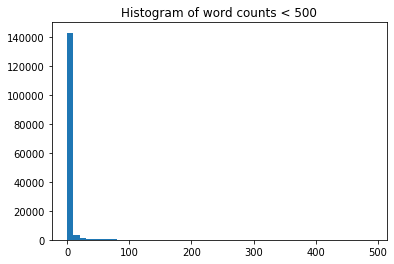

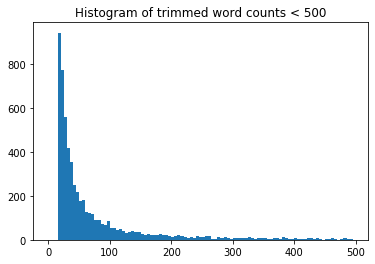

In [47]:
# Count of words for each appearance
hist_breaks = np.arange(0, 500, 10)
plt.hist(word_count_list, bins = hist_breaks)
plt.title('Histogram of word counts < 500')
plt.show()

# Too many words appear few times. Check out trimmed.
trimmed_word_counts = doc_term_mat_trimmed.sum(axis=0)
trimmed_word_list = trimmed_word_counts.tolist()[0]
hist_breaks = np.arange(0, 500, 5)
plt.hist(trimmed_word_list, bins = hist_breaks)
plt.title('Histogram of trimmed word counts < 500')
plt.show()

Note that 15 might be a good cutoff because we get a visible drop off and for our next model, ~6000 features may not be too much.  These type of parameters, (cutoff), are **hyperparameters** for the model and will need tuning that is dependent on the model. You may consider trying different preprocessing steps and cutoffs and compare performances.

The best way to find the cutoff is to test various model preprocessing through a train-test-validation split.  Train multiple versions and compare them on the test set.  Then report the best resulting model's performance on the validation set.

### Now what?

Now we have a matrix of data that we can consider as observations with our target to predict, 'sentiment'.  We could use each column (each column is an observance if a specific word occurs in a tweet) as a feature for predicting sentiment in a predictive model, e.g.- a logistic regression.

This is done frequently, but we have a problem that word occurrences do not have a linear effect on much of anything. For example, the more frequently a word occurs, the less informative it can be (e.g., the word 'a' or 'the'), but words that rarely occur (e.g., 'aaaaa') are probably not very informative either. If we are interested in finding important words, we must look for words in between 'aaaaa' and 'a' in usage.

The next idea we will explore is called 'TF-IDF', or 'Term Frequency-Inverse Document Frequency'.  Here we will be looking for rare words overall, but common inside individual documents.  It is these words that hold a lot of meaning to the document they reside in.

### Computing Term Frequency

Now that we have computed a document-term matrix, how can we understand it? Recall that the simple **Bag of Words model** is just based on **Term Frequency (TF)**. In this case, the weighting of a document for a given term is just the frequency of that term in the document. 

In other cases we will used the **Inverse Document Frequency (IDF)** weighting. IDF weighting accounts for cases where only a few documents contain certain terms. The formula for the IDF weighting can be written as:

$$IDF = log(\frac{Number\ Documents}{Number\ Documents\ with\ Word})$$

The IDF can exhibit a problem however. When there are a few documents with very frequent terms, the weighting is skewed toward those documents.  To solve this problem, we reweight IDF by the overall frequency of the word to create a **term frequency-inverse document frequency (TF-IDF)** matrix. The formula for computing TFIDF is: 

$$TF - IDF = frequency(word) \cdot log(\frac{Number\ Documents}{Number\ Documents\ with\ Word})\ $$

The code in the cell below computes both simple TF and the cumulative of the term frequencies, starting from the most frequent terms to the least.

Scikit-Learn has a built in TF-IDF transformation function that we will use to calculate this and prepare the dataset.

In [48]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=6228, stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = tweet_df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

In [49]:
# Scikit learn prefers the 'csr' format instead (Compressed Sparse Row format)
tf_idf_tweets

<160000x6228 sparse matrix of type '<class 'numpy.float64'>'
	with 854733 stored elements in Compressed Sparse Row format>

## Classification and Sentiment Analysis - Quiz Point 2

Now that we have a prepared TDM of the 160,000 tweets, let's build and evaluate models to classify the sentiment of these tweets. An outline of our process is as follows:

- Use TDM or TF-IDF weighted TDM as features for training the model.
- Use marked cases for training and evaluation of model.
- Select a method for sparse matrix requires regularization from the following:
  - Feature selection, is impractical since there are over one million features.
  - SVD/PCA could be used to reduce dimensionality of the problem.
  - In this case we will use the ridge and lasso methods offered in the  elasticnet model.

For training we will use 120,000 tweets to predict the 0,1 sentiment. The remaining 40,000 cases will be used to evaluate the model.

Let's split the tf-idf sparse matrix:

In [50]:
# Generate 40,000 random row indices
print('Splitting into train-test. Please wait!')
from sklearn.model_selection import train_test_split

y_targets = np.array([y[0] for y in tweet_data])

X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size=40000,
                                                    random_state=42)
print('Done!')

Splitting into train-test. Please wait!
Done!


Now let's train a logistic classifier on the data:

In [51]:
print('Starting a standard Logistic Model training!')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Done.')

Starting a standard Logistic Model training!
Done.


C:\Users\ly266e\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [52]:
# Look at model object
lr

LogisticRegression()

### Evaluating our model:

In [53]:
## Compute results on the train and test set
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [54]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7801666666666667
Test accuracy: 0.7563


The coded in the cell below computes the precision, recall and Fscore of the model for positive and negative tweets. Execute the code and examine the results. 

In [55]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Remember:
# Precision is the proportion of correct predictions among all predicted
# Recall (sensitivity) is the proportion of correct predictions among all true actual examples
# F1 is the harmonic average of precision and recall
# Support is count of actual cases of specific class
# Here, each of the following is a pair of numbers, the first is for class 1 ('1') and second for class 0 ('0')
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[14597  5459]
 [ 4289 15655]]
             Class 1   -   Class 0
Precision: [0.77290056 0.74145117]
Recall   : [0.72781213 0.78494785]
F1       : [0.74967901 0.76257977]
Support  : [20056 19944]


### Regularized Logistic Regression

Let us try to improve the results with some regularization.  Here we will use elastic net type regulariation on our logistic regression to see if that helps.  Regularization can also help with the slight over training we have done.

You can see that we have slightly over trained because our accuracy on our training set is greater than our test set.

The way that Scikit-Learn solves for logistic regression is with a technique called stochastic gradient descent (SGD). We will need to import this and give the function some objective constraints to introduce elasticnet regularization.

In [56]:
print('Starting training regularized logistic regression')
from sklearn.linear_model import SGDClassifier
lr_reg = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
lr_reg.fit(X_train, y_train)
print('Done!')

Starting training regularized logistic regression
Done!


In [57]:
# Look at model object
lr_reg

SGDClassifier(loss='log', penalty='elasticnet')

### Evaluate our model!

In [58]:
## Compute results on the train and test set
train_probs = lr_reg.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr_reg.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [59]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7528583333333333
Test accuracy: 0.7462


Notice how our train and test accuracies are much closer together!  Although we lost ~1 percentage point in the accuracy, we might consider accepting this because it is less over fit to our training set.

In [60]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Remember:
# Precision is the proportion of correct predictions among all predicted
# Recall (sensitivity) is the proportion of correct predictions among all true actual examples
# F1 is the harmonic average of precision and recall
# Support is count of actual cases of specific class
# Here, each of the following is a pair of numbers, the first is for class 1 ('1') and second for class 0 ('0')
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[14170  5886]
 [ 4266 15678]]
             Class 1   -   Class 0
Precision: [0.7686049  0.72704508]
Recall   : [0.70652174 0.78610108]
F1       : [0.73625688 0.75542064]
Support  : [20056 19944]



####  Document Classification, Topic Models, and Information Retrieval

A common objective of text analysis is to classify and group documents. These methods have application in information retrieval and search. Understandably, there are a great many such methods which have been developed over the years. We will only discuss a few examples in this tutorial.    

- **Classification** is a widely used supervised learning method for document analysis. For example, documents can be classified as SPAM  or not SPAM or as positive or negative sentiment. 
- **Latent Semantic Analysis (LSA)** and **Doc-to-Vec** analysis are unsupervised learning methods used to determine which documents are closely related. These methods use similarity measures to rank documents as being related. These powerful methods are beyond the scope of this tutorial. 
- **Topic models** are an method wherein the a set of documents is categorized by one or more **topics**. analysis are unsupervised learning methods used to determine which documents are closely related. These methods use similarity measures to rank documents as being related.  
  - **Latent Dirichlet Allocation (LDA)** allocates the probability that a document contains a topic.
  - **Latent Semantic Analysis (LSA)** and **Doc-to-Vec**  These powerful methods are beyond the scope of this tutorial. 
- A variety of **distance metrics** have been developed to determine the distance between words, sentences and documents. These methods are related to coding theory widely used in telecommunications engineering.
- **Clustering methods** are unsupervised learning models which seek to group similar documents into clusters. A variety of distance metrics can be used to define the structure of text clusters. 
  - K-means 
  - Hierarchical

## Topic Models

It is often useful to allocate documents to one or more topics. This process can be useful in, say, information retrieval and search. Models to perform this allocation to topics are known as **topic models**. 

A powerful topic model is know as **Latent Dirichlet Allocation** or **LDA**. LDA is an unsupervised Bayesian learning model.  We can summarize the LDA model as follows:

- The LDA model uses a fixed number of (sub) topics, k.
- The model computes the posterior probability of a document containing a topic.
- The model uses know word frequencies for documents in corpus, e.g. the tdm.
- All other variables are estimated or **latent**, including the topics of each document. 

How does Latent Dirichlet allocation work? It's a Bayesian model, so we need to define a likelihood and choose a prior. 

Our posterior distribution is categorical, since we have many topics. The Dirichlet distribution is the conjugate of the multinomial and categorical distributions.

All we actually know: $w_{ij}$ is the frequency of a specific word $j$ in document $i$.

What we want to know (latent): $\theta_i$ is the topic distribution of document $i$.

We also need to estimate (latent):
- $\phi_k$ is the word distribution for topic $k$
- $z_{ij}$ is the topic of the jth word in document $i$

The Bayesian model and its priors:

- Multinomial model
$$z_{ij} \sim Multinomial(\theta_i)\\
w_{ij} \sim Multinomial(\phi_k)$$

- With Dirichlet priors with parameters $\alpha$ and $\beta$:
$$\theta_i \sim Dirichelet(\alpha)\\
\phi_k \sim Dirichelet(\beta)$$

Since we don't know the allocation of topics in advance we generally use uniform priors across topics.

The Likelihood is taken from the term-document matrix.

## After trying multiple times I could not install the LDS package, therefore the following section was not explored. 

## LDA Model Example
Let's try an example. In this example we apply LDA to a corpus of 20 business news articles from Reuters news wire concerning the oil industry. We will apply an LDA model with 5 topics ($k = 5$). 

As a first step we will load the corpus of these documents. Execute the code in the cell below to load the corpus and examine the contents of the first document. 

In [61]:
# ## Load the data set as a vector corpus of 20 documents
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.decomposition import NMF, LatentDirichletAllocation
# from sklearn.datasets import fetch_20newsgroups

# n_samples = 3000
# n_features = 500
# n_components = 10
# n_top_words = 5

# # Function below taken from Scikit Learn documentation
# def print_top_words(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic #{}: ".format(topic_idx)
#         message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#     print()


# # Load the news dataset
# print("Loading data set. Please wait.")
# news_data = fetch_20newsgroups(shuffle=True, remove=('headers', 'footers', 'quotes'))
# small_data = news_data.data[:n_samples]
# print('Done!')

In [62]:
# # We need the counts (frequencies of the words as well)

# count_vectorizer = CountVectorizer(max_df=0.9, min_df=5, max_features=n_features, stop_words='english')
# tf = count_vectorizer.fit_transform(small_data)

In [63]:
# tf

In [64]:
# # Train LDA model
# print('Starting LDA model training.')
# lda = LatentDirichletAllocation(n_components, max_iter=5, learning_method='online', learning_offset=50.)
# lda.fit(tf)
# print('Done!')

In [65]:
# print("Topics in LDA model:")
# tf_feature_names = count_vectorizer.get_feature_names()
# print_top_words(lda, tf_feature_names, n_top_words)

## Your Turn 4
True of False: "The LDA topic model will come with the same key-words for the 10 topics above everytime."

False. Well it is a difficult question. Provided it is the same data set and you run it under the same assumptions then yes, but then if you start adding more data or include more files then our prior distribution might change as a consequence the worlds for the topics we want to identify will change this as Latent Dirichlet allocation is a Bayesian model.

## Summary
In this notebook you have worked through the following:
- Quantifying text
- Text Cleaning and Preprocessing
- Classification and Sentiment Analysis

<div id="reminder" style="border-radius: 5px; background-color:#f5f5f5;" >
<h3>Reminder</h3>
<p>Use this notebook to answer the quiz questions related to the <b>Quiz Point</b> sections.<p>
</div>